In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(16,9)})

# Import Data and Preprocessing

In [76]:
column1 = ["machine_name", "cycle", "operational_setting_1", "operational_setting_2", "operational_setting_3"]
column2 = [f'sensor_measurement_{i:02}' for i in range(1,22)]
columns = column1 + column2

In [77]:
turbofan_df = pd.read_csv("dataset/train_FD002.txt", header = None, sep = "\s+", names = columns)
turbofan_df.head()

,machine_name,cycle,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_01,sensor_measurement_02,sensor_measurement_03,sensor_measurement_04,sensor_measurement_05,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


## Select the Maximum Cycle for Each Machine Name

In [78]:
max_cycle = turbofan_df.groupby(by = "machine_name")['cycle'].transform(max)
turbofan_df = turbofan_df[turbofan_df["cycle"] == max_cycle].set_index('machine_name')
turbofan_df.head()

,cycle,operational_setting_1,operational_setting_2,operational_setting_3,sensor_measurement_01,sensor_measurement_02,sensor_measurement_03,sensor_measurement_04,sensor_measurement_05,sensor_measurement_06,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
machine_name,,,,,,,,,,,,,,,,,,,,,
1,149,42.0017,0.8414,100.0,445.00,550.49,1366.01,1149.81,3.91,5.71,...,129.55,2387.40,8066.19,9.4765,0.02,332,2212,100.0,10.45,6.2285
2,269,42.0047,0.8411,100.0,445.00,550.11,1368.75,1146.65,3.91,5.72,...,129.76,2388.42,8110.26,9.4315,0.02,334,2212,100.0,10.56,6.2615
3,206,42.0073,0.8400,100.0,445.00,550.80,1356.97,1144.89,3.91,5.72,...,130.02,2387.87,8082.25,9.4962,0.02,333,2212,100.0,10.46,6.3349
4,235,0.0030,0.0007,100.0,518.67,643.68,1605.86,1428.21,14.62,21.61,...,520.25,2388.17,8215.14,8.5784,0.03,397,2388,100.0,38.47,22.9717
5,154,42.0049,0.8408,100.0,445.00,550.53,1364.82,1146.87,3.91,5.72,...,130.05,2389.19,8151.36,9.4339,0.02,333,2212,100.0,10.74,6.3906


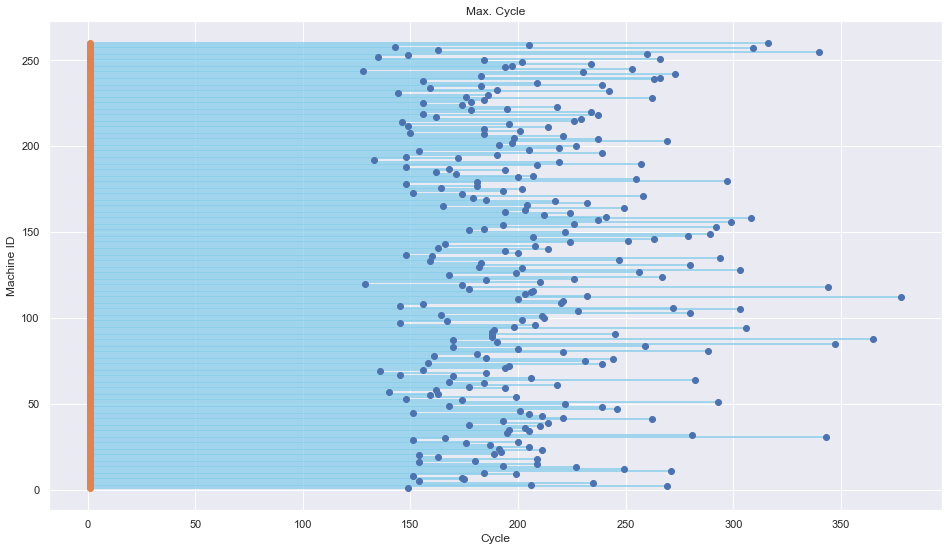

In [80]:
# Lollipop plot for each machine name
plt.hlines(y=turbofan_df.index, xmin=1, xmax=turbofan_df['cycle'], color='skyblue')
plt.plot(turbofan_df['cycle'], turbofan_df.index, "o")
plt.plot([1 for i in range(len(turbofan_df))], turbofan_df.index, "o")

# Add titles and axis names
plt.title("Max. Cycle")
plt.xlabel('Cycle')
plt.ylabel('Machine ID')

# Show the plot
plt.show()

> We can assume that the end of study is when the cycle reach 220. So when the machine still active after 220 cycle would be right censored sample

In [81]:
# Create status column
turbofan_df['status'] = turbofan_df['cycle'].apply(lambda x: False if x > 220 else True)

# Exploratory Data Analysis

In this section, we will determined which columns that would be involved in our model.

## Check Uniqueness

First we can check the number of unique values for each columns. Then for columns that have a few unique values, we can change the data type of the columns to category

In [82]:
turbofan_df.nunique()

cycle                    133
operational_setting_1    165
operational_setting_2     62
operational_setting_3      2
sensor_measurement_01      6
sensor_measurement_02    188
sensor_measurement_03    257
sensor_measurement_04    251
sensor_measurement_05      6
sensor_measurement_06      8
sensor_measurement_07    209
sensor_measurement_08    177
sensor_measurement_09    259
sensor_measurement_10      8
sensor_measurement_11    123
sensor_measurement_12    198
sensor_measurement_13    152
sensor_measurement_14    258
sensor_measurement_15    247
sensor_measurement_16      2
sensor_measurement_17     27
sensor_measurement_18      6
sensor_measurement_19      2
sensor_measurement_20    135
sensor_measurement_21    253
status                     2
dtype: int64

> We can change `operational_setting_3`, `sensor_measurement_01`, `sensor_measurement_05`, `sensor_measurement_06`, `sensor_measurement_10`, `sensor_measurement_16`, `sensor_measurement_18`, `sensor_measurement_19` columns to category type.

In [83]:
# Change to category
category_columns = ['operational_setting_3', 'sensor_measurement_01', 'sensor_measurement_05',
                    'sensor_measurement_06', 'sensor_measurement_10', 'sensor_measurement_16', 
                    'sensor_measurement_18', 'sensor_measurement_19']

turbofan_df[category_columns] = turbofan_df[category_columns].astype('category')
turbofan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 1 to 260
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   cycle                  260 non-null    int64   
 1   operational_setting_1  260 non-null    float64 
 2   operational_setting_2  260 non-null    float64 
 3   operational_setting_3  260 non-null    category
 4   sensor_measurement_01  260 non-null    category
 5   sensor_measurement_02  260 non-null    float64 
 6   sensor_measurement_03  260 non-null    float64 
 7   sensor_measurement_04  260 non-null    float64 
 8   sensor_measurement_05  260 non-null    category
 9   sensor_measurement_06  260 non-null    category
 10  sensor_measurement_07  260 non-null    float64 
 11  sensor_measurement_08  260 non-null    float64 
 12  sensor_measurement_09  260 non-null    float64 
 13  sensor_measurement_10  260 non-null    category
 14  sensor_measurement_11  260 non-null    flo

## Correlation Heatmap

After that, we can check the correlation for each columns to inspect if there is a high correlation in our predictor

<AxesSubplot:>

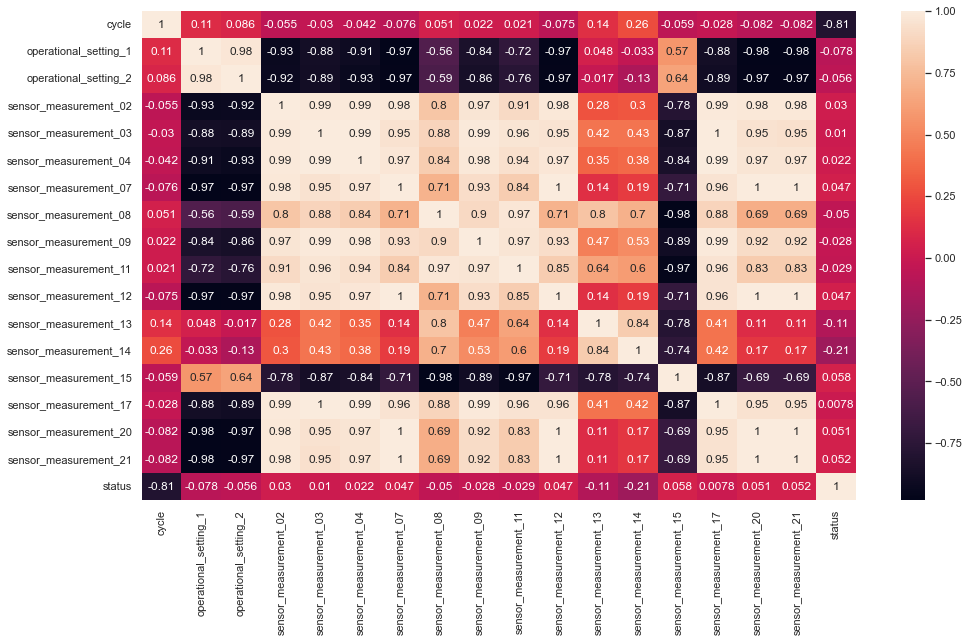

In [84]:
sns.heatmap(turbofan_df.corr(), annot = True,)

> 

<AxesSubplot:>

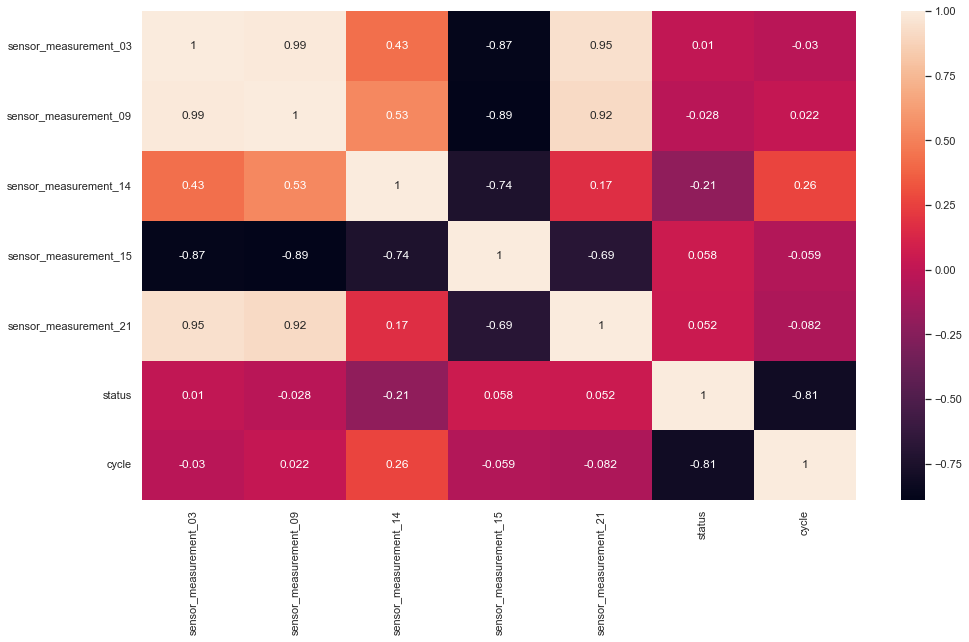

In [123]:
selected_columns = ['sensor_measurement_03', 'sensor_measurement_09', 'sensor_measurement_14', 
                    'sensor_measurement_15', 'sensor_measurement_21']
cleaned_data = turbofan_df.loc[:, selected_columns + category_columns + ['status', 'cycle']]
sns.heatmap(cleaned_data.corr(), annot = True)

# Data Preparation for Modeling

In [124]:
# One Hot Encoding for Categorical Variable
from sksurv.preprocessing import OneHotEncoder

data_x = OneHotEncoder().fit_transform(cleaned_data.iloc[:, :-2])
data_x.head()

,sensor_measurement_03,sensor_measurement_09,sensor_measurement_14,sensor_measurement_15,sensor_measurement_21,operational_setting_3=100.0,sensor_measurement_01=449.44,sensor_measurement_01=462.54,sensor_measurement_01=489.05,sensor_measurement_01=491.19,...,sensor_measurement_10=1.08,sensor_measurement_10=1.26,sensor_measurement_10=1.3,sensor_measurement_16=0.03,sensor_measurement_18=2212,sensor_measurement_18=2223,sensor_measurement_18=2319,sensor_measurement_18=2324,sensor_measurement_18=2388,sensor_measurement_19=100.0
machine_name,,,,,,,,,,,,,,,,,,,,,
1,1366.01,8307.72,8066.19,9.4765,6.2285,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1368.75,8358.80,8110.26,9.4315,6.2615,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1356.97,8329.26,8082.25,9.4962,6.3349,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1605.86,9150.14,8215.14,8.5784,22.9717,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
5,1364.82,8397.52,8151.36,9.4339,6.3906,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [125]:
# Preprocessing for target variable

data_y = list(cleaned_data.iloc[:, -2:].itertuples(index = None, name = None))
data_y = np.array(data_y, dtype=[('status', bool), ('cycle', float)])
data_y

array([( True, 149.), (False, 269.), ( True, 206.), (False, 235.),
       ( True, 154.), ( True, 175.), ( True, 174.), ( True, 151.),
       ( True, 199.), ( True, 184.), (False, 271.), (False, 249.),
       (False, 227.), ( True, 193.), ( True, 209.), ( True, 154.),
       ( True, 180.), ( True, 209.), ( True, 163.), ( True, 154.),
       ( True, 189.), ( True, 192.), ( True, 211.), ( True, 191.),
       ( True, 205.), ( True, 187.), ( True, 176.), ( True, 200.),
       ( True, 151.), ( True, 166.), (False, 343.), (False, 281.),
       ( True, 195.), ( True, 205.), ( True, 196.), ( True, 203.),
       ( True, 210.), ( True, 177.), ( True, 214.), ( True, 193.),
       (False, 262.), (False, 221.), ( True, 211.), ( True, 205.),
       ( True, 151.), ( True, 201.), (False, 246.), (False, 239.),
       ( True, 168.), (False, 222.), (False, 293.), ( True, 174.),
       ( True, 148.), ( True, 199.), ( True, 159.), ( True, 163.),
       ( True, 140.), ( True, 162.), ( True, 194.), ( True, 17

# Kaplan Meier Estimator

Text(0.5, 0, 'time $t$')

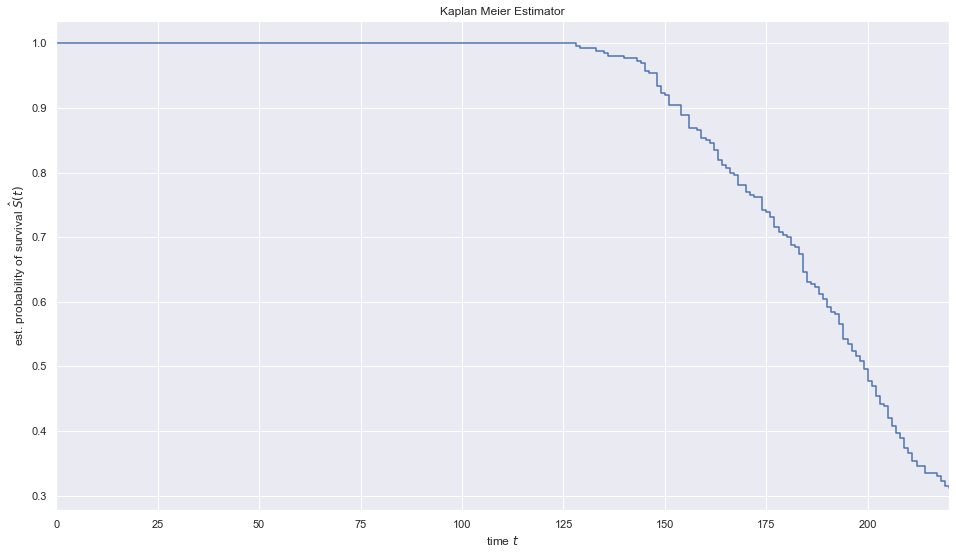

In [126]:
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["status"], data_y["cycle"])
time, survival_prob = np.append(0, time), np.append(1, survival_prob)
plt.step(time, survival_prob, where = "post")
plt.xlim(left = 0, right = 220)
plt.title("Kaplan Meier Estimator")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

## Compare Survival Time for Each Category in Every Categorical Columns

In this section, we will compare the distribution of survival time for each category in every categorical columns. From the distribution we hope that we can determined if there is a difference distribution for each category or not.

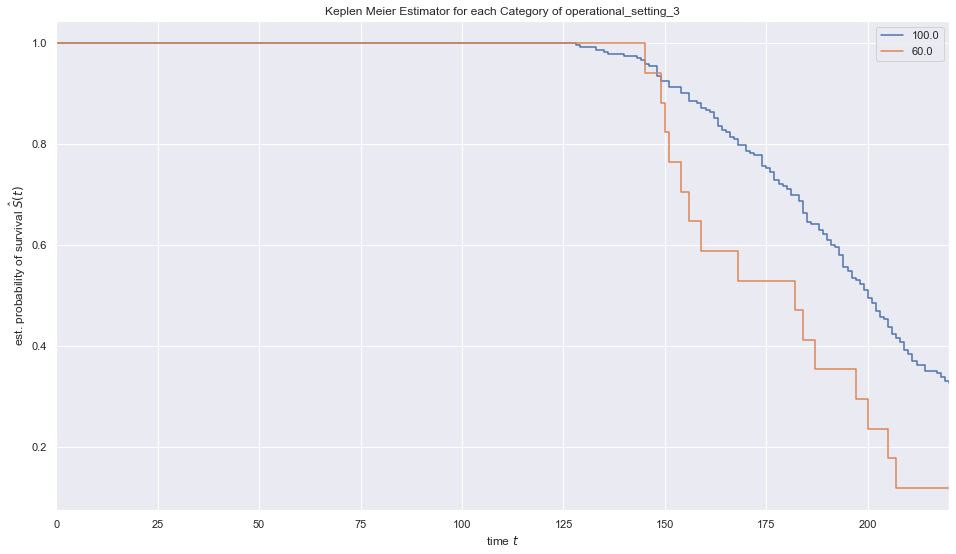

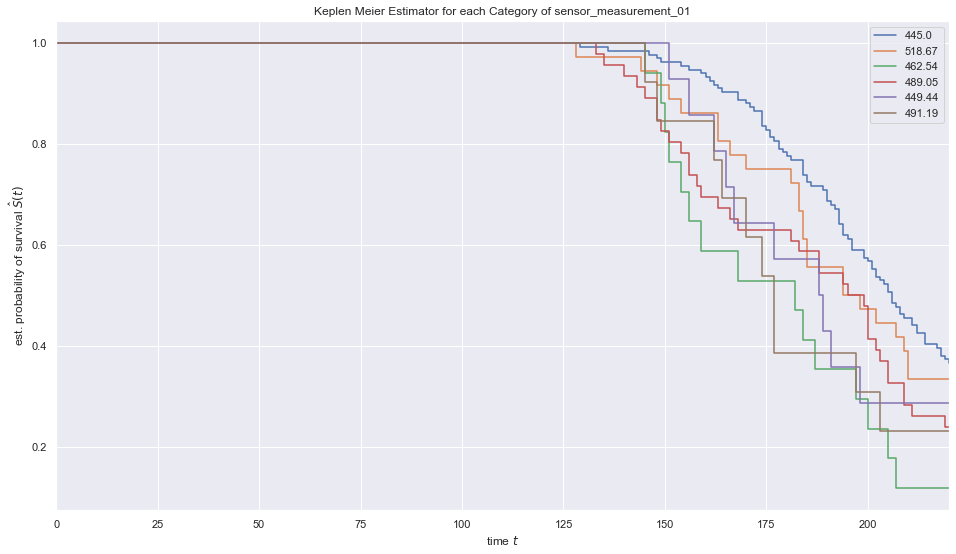

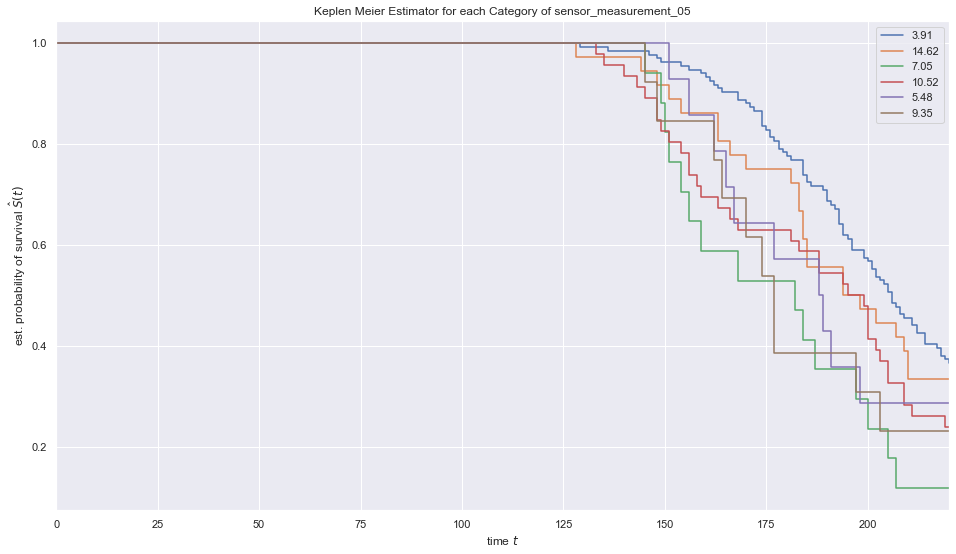

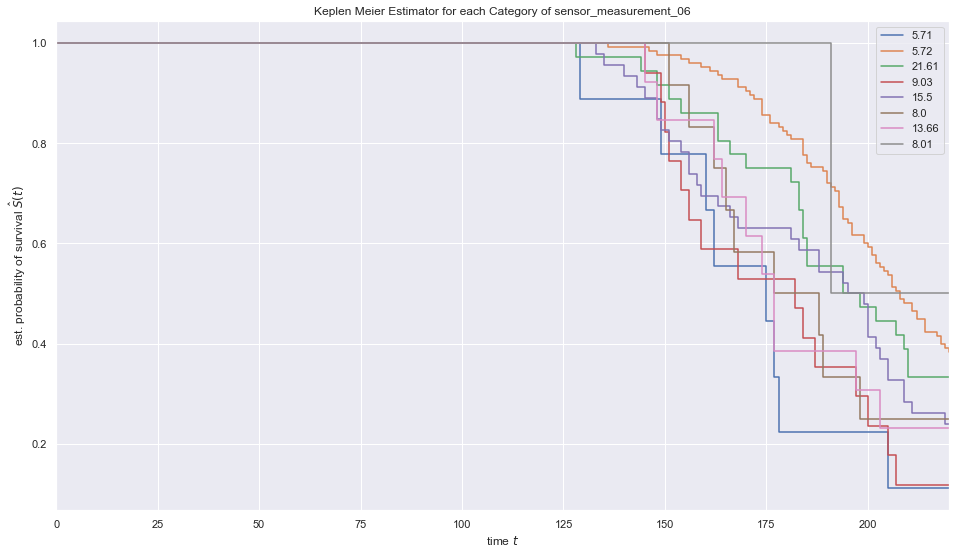

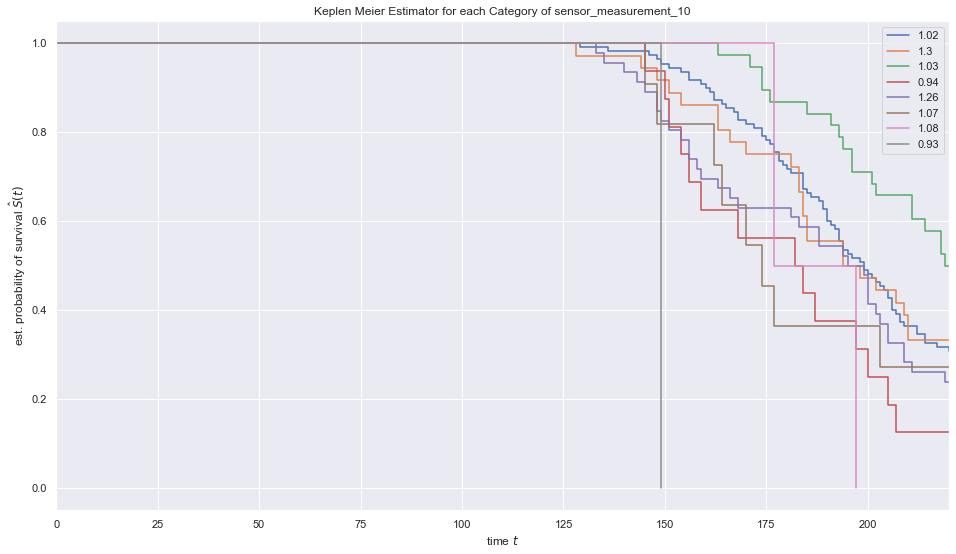

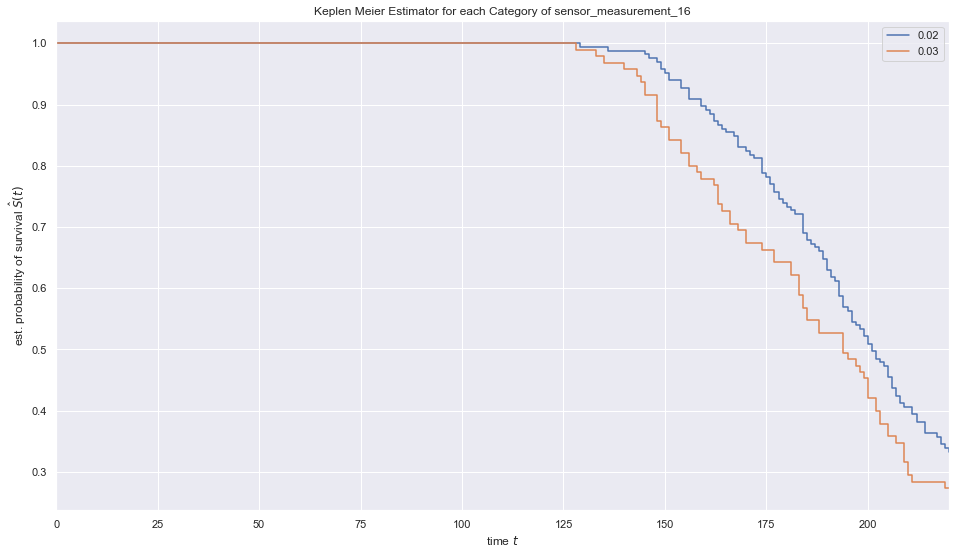

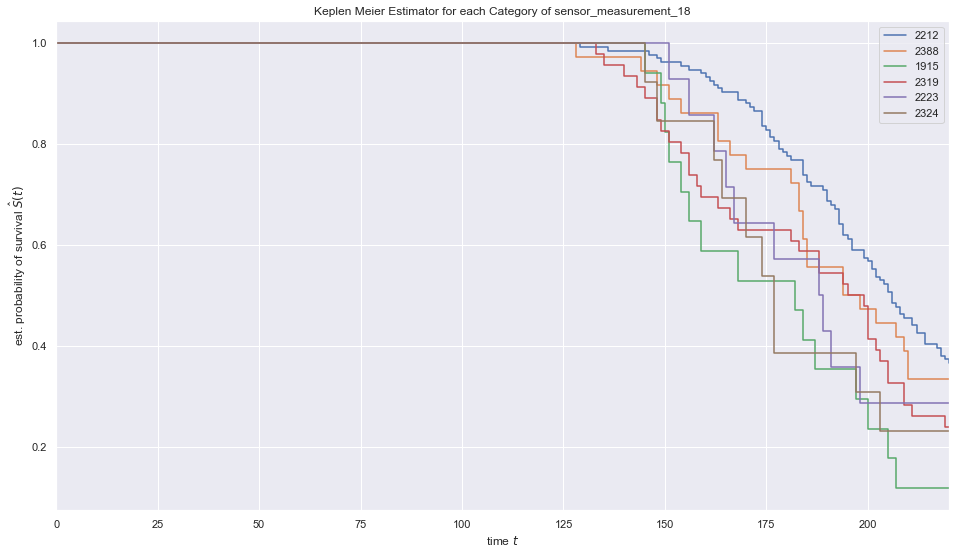

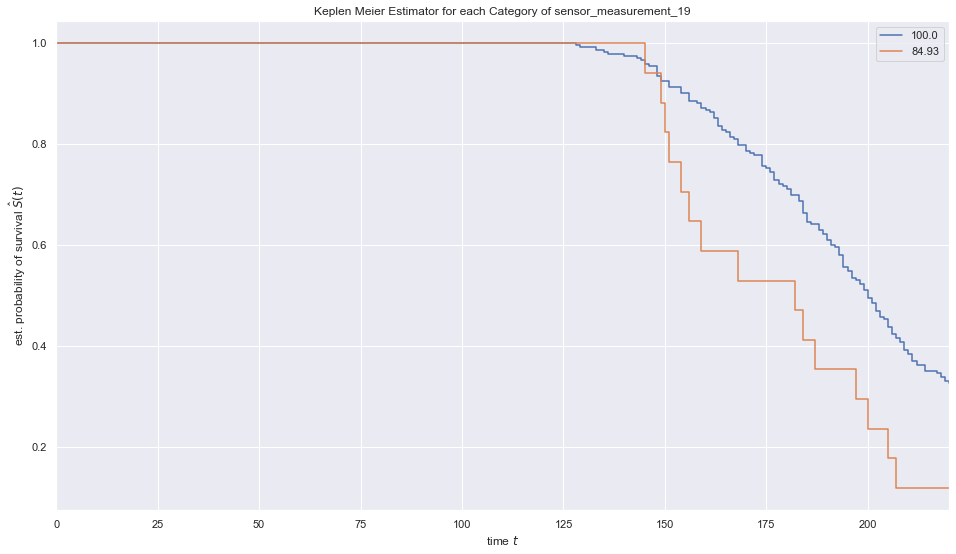

In [127]:
for column in category_columns:
    for category in cleaned_data[column].unique():
        category_df = cleaned_data[cleaned_data[column] == category]
        time_treatment, survival_prob_treatment = kaplan_meier_estimator(category_df['status'],
                                                                         category_df['cycle'])
        time_treatment , survival_prob_treatment = np.append(0, time_treatment), np.append(1, survival_prob_treatment)
        plt.step(time_treatment, survival_prob_treatment, where = "post", label = category)

    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.title(f"Keplen Meier Estimator for each Category of {column}")
    plt.legend(loc="best")
    plt.xlim(left = 0, right = 220)
    plt.show()

# Log-Rank Test

In [128]:
from sksurv.compare import compare_survival

p_value_list = []
for column in category_columns:
    p_value = compare_survival(data_y, turbofan_df[column])[1]
    p_value_list.append(p_value)
    
result = pd.DataFrame({'columns': category_columns, 'p-value': p_value_list}).set_index('columns')
result['conclusion'] = result['p-value'].apply(lambda x: "significant" if x < 0.05 else "not significant")
result

,p-value,conclusion
columns,,
operational_setting_3,0.006857,significant
sensor_measurement_01,0.010938,significant
sensor_measurement_05,0.010938,significant
sensor_measurement_06,0.001006,significant
sensor_measurement_10,0.000259,significant
sensor_measurement_16,0.106360,not significant
sensor_measurement_18,0.010938,significant
sensor_measurement_19,0.006857,significant


> **Conclusion** : There is no difference survival time distribution for different category in `sensor_measurement_16` so we can eliminate this column in our predictor

In [129]:
data_x = data_x[data_x.columns[~data_x.columns.isin(["sensor_measurement_16=0.03"])]]

# Cox Propotional Hazard

In [130]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis(alpha = 1e-4)
estimator.fit(data_x, data_y)

CoxPHSurvivalAnalysis(alpha=0.0001)

In [131]:
# Coef model
pd.Series(estimator.coef_, index = data_x.columns)

sensor_measurement_03           0.023905
sensor_measurement_09          -0.033005
sensor_measurement_14           0.024575
sensor_measurement_15           2.494561
sensor_measurement_21           1.446012
operational_setting_3=100.0     1.150699
sensor_measurement_01=449.44   -0.312533
sensor_measurement_01=462.54   -1.150699
sensor_measurement_01=489.05   -0.234179
sensor_measurement_01=491.19    0.321888
sensor_measurement_01=518.67   -0.532719
sensor_measurement_05=5.48     -0.312533
sensor_measurement_05=7.05     -1.150699
sensor_measurement_05=9.35      0.321888
sensor_measurement_05=10.52    -0.234179
sensor_measurement_05=14.62    -0.532719
sensor_measurement_06=5.72     -0.840521
sensor_measurement_06=8.0      -0.314570
sensor_measurement_06=8.01      0.002036
sensor_measurement_06=9.03     -1.150699
sensor_measurement_06=13.66     0.321888
sensor_measurement_06=15.5     -0.234179
sensor_measurement_06=21.61    -0.532719
sensor_measurement_10=0.94     -1.966696
sensor_measureme

**Interpretation:**



# Model Evaluation

In [132]:
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(data_x)
result = concordance_index_censored(turbofan_df["status"], turbofan_df["cycle"], prediction)
result[0]

0.6646044926721143

In [133]:
estimator.score(data_x, data_y)

0.6646044926721143